# Исследование гипотез и проведение A/B-теста для интернет-магазина

**Цель проекта**: выявить и проанализировать наилучшую гипотезу для увеличения выручки в интернет-магазине.

Задачи исследования:

* приоритизация гипотез;
* проведение A/B-теста и изучение его результатов:
    * подготовка данных для анализа;
    * оценка кумулятивных метрик;
    * анализ выбросов;
    * проверка статистической значимости различий метрик.
    
Для исследования были предоставлены данные с итогами проведения анализа гипотез и результатами A/B-тестирования.

Сначала приоритизируем гипотезы с помощью фреймворков `ICE` и `RICE` и выберем гипотезу для тестирования. Затем проведем A/B-тест, результаты которого проанализируем, и примем решение об остановке теста или его продолжении.

## Приоритизация гипотез

Перед началом работы импортируем необходимые библиотеки и компоненты.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import datetime as dt
from matplotlib import pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

Рассмотрим файл с гипотезами, для этого сохраним его в переменной `hypothesis` и выведим основную информацию по датасету.

In [2]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('display.max_colwidth', -1)
hypothesis

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
Hypothesis    9 non-null object
Reach         9 non-null int64
Impact        9 non-null int64
Confidence    9 non-null int64
Efforts       9 non-null int64
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


Все столбцы в таблице с нужными типами данных. Датафрейм содержит следующую информацию:

* Hypothesis — краткое описание гипотезы;
* Reach — охват пользователей по 10-балльной шкале;
* Impact — влияние на пользователей по 10-балльной шкале;
* Confidence — уверенность в гипотезе по 10-балльной шкале;
* Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале.

Применим фреймворк `ICE` для приоритезации гипотез. В него входят параметры: `Impact`, `Confidence` и `Efforts`. Затем выведим отсортированную по убыванию таблицу с кратким описанием гипотезы и значением `ICE`.

In [4]:
hypothesis['ICE'] = ((hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']).round(2)
hypothesis[['Hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,Hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Получается, что самыми перспективными являются гипотезы с индексами 8, 0 и 7. Посмотрим теперь на фреймворк `RICE`. К предыдущим параметрам `ICE` добавляется еще параметр `Reach`.

In [5]:
hypothesis['RICE'] = (hypothesis['Reach']*hypothesis['Impact']*hypothesis['Confidence'])/hypothesis['Efforts']
hypothesis[['Hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,Hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


При добавлении параметра `Reach` порядок расположения гипотез поменялся. Теперь это гипотезы 7, 2 и 0. Это произошло из-за того, что охват у 7 и 0 гипотез выше, чем у остальных. Это один из важных показателей, поскольку для увеличения выручки важно охватить, как можно большее число пользователей, а не конкретную узкую группу.

Рассмотрим по отдельности параметры из первоначальной таблицы у всех 4 гипотез, которые входили в тройку лидеров в двух датафреймах - гипотезы 0, 2, 7 и 8.

Начнем с 0 гипотезы "Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей". Она имеет небольшой охват по аудитории - 3 балла по 10-балльной шкале, поскольку это изменение затронет только небольшой сегмент пользователей, которые будут использовать два канала. Зато у этой гипотезы максимальное влияние на аудиторию и высокая степень уверенности (8 баллов). Однако, ее проверять довольно затратно: 6 баллов по 10-балльной шкале, что соответствует затратам выше среднего.

Следующая гипотеза 2 "Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа". У нее высокий охват аудитории (8 баллов) и высокая степень уверенности (7 баллов), при этом, низкие степень влияния и стоимость проверки по 3 балла.

Гипотеза 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" имеет максимальную оценку по охвату аудитории, т.к. изменения коснутся всех страниц, и эти изменения увидят все пользователи, также высокий показатель по степени влияния (7 баллов), высокая уверенность в оценке показателей (8 баллов) и средние затраты на проведение проверки гипотезы (5 баллов).

И, наконец, гипотеза 8 "Запустить акцию, дающую скидку на товар в день рождения". Она имеет низкий охват аудитории, т.к. не все указывают свой день рождения в профиле и необязательно им потребуется делать заказ именно в свой день рождения. У этой гипотезы практически максимальные степени влияния и уверенности - 9 баллов. Затраты на ее проверку находятся на среднем уровне (5 баллов).

**Вывод**

Проанализировав значения двух фреймворков - `ICE` и `RICE`, а также отдельные параметры, было принято решение провести тестирование гипотезы 7 "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок". Она имеет максимальный охват, высокую степень влияния на пользователей, средний уровень затрат на ее проверку и позволяет с большой уверенностью оценить параметры.

## Анализ A/B-теста

### Подготовка данных для анализа

Было проведено тестирование гипотезы 7, результаты доступны в двух файлах. Сохраним каждый файл в своей переменной и проанализируем данные. Начнем с файла с заказами.

In [6]:
orders = pd.read_csv('/datasets/orders.csv')
orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Таблица состоит из 1197 строк, в которых такие данные:

* transactionId — идентификатор заказа;
* visitorId — идентификатор пользователя, совершившего заказ;
* date — дата, когда был совершён заказ;
* revenue — выручка заказа;
* group — группа A/B-теста, в которую попал заказ.

Тип данных неправильно указан у столбца `date`, переведем его в подходящий тип для даты. Затем проверим исправление и посмотрим, есть ли дубликаты строк.

In [8]:
orders['date'] = orders['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null datetime64[ns]
revenue          1197 non-null int64
group            1197 non-null object
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [9]:
orders.duplicated().sum()

0

Дубликатов не нашлось. Проверим, нет ли пользователей, которые попали в обе группы теста.

In [10]:
orders_grouped = orders.groupby('visitorId').agg({'group': 'nunique'})
usersInTwoGroups = orders_grouped[orders_grouped['group'] == 2].reset_index()
usersInTwoGroups.shape

(58, 2)

58 пользователей попали в обе группы. Нужно сообщить об этом коллегам, которые занимались распределением пользователей.

Теперь перейдем к файлу с визитами.

In [11]:
visitors = pd.read_csv('/datasets/visitors.csv')
visitors.head()

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [12]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


В этой таблице всего 62 строки со столбцами:

* date — дата;
* group — группа A/B-теста;
* visitors — количество пользователей в указанную дату в указанной группе A/B-теста

Также необходимо поменять тип данных у столбца с датой.

In [13]:
visitors['date'] = visitors['date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null datetime64[ns]
group       62 non-null object
visitors    62 non-null int64
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [14]:
visitors.duplicated().sum()

0

Дубликатов также нет, тип данных изменен успешно.

**Вывод**

После проведения A/B-теста было сформировано два файла, в которых дана информация по заказам и количеству пользователей в каждой группе на определенную дату. В обоих файлах нужно было привести к правильному типу данные в столбце `date`. В таблице с заказами обнаружились пользователи, которые попали в обе группы тестирования. Информацию передали коллегам, которые занимались распределением людей по группам.

### Кумулятивные метрики

Сначала создадим таблицу, в которой соберем все кумулятивные данные.

In [15]:
# создадим массив из уникальных пар дат и групп
datesGroups = orders[['date', 'group']].drop_duplicates()

# собираем агрегированные кумулятивные данные о заказах по дням
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
                                     .agg({'date':'max', 
                                           'group':'max', 
                                           'transactionId':pd.Series.nunique, 
                                           'visitorId':pd.Series.nunique, 
                                           'revenue':'sum'}), axis=1).sort_values(by=['date', 'group'])

# собираем агрегированные кумулятивные данные о посетителях по дням
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
                                      .agg({'date':'max', 
                                            'group':'max', 
                                            'visitors':'sum'}), axis=1).sort_values(by=['date', 'group'])

# соединяем две таблицы с кумулятивными данными и переименновываем столбцы
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']
cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,21,20,101217,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,45,43,266748,1294
4,2019-08-03,A,68,62,354874,1845


Получилась таблица со следующими столбцами:

* date - дата;
* group - группа A/B-теста;
* orders - количество заказов;
* buyers - число покупателей;
* revenue - общая выручка за день;
* visitors - число посетителей.

Далее будем работать с этой таблицей.

#### Кумулятивная выручка по группам

Создадим две переменные, в которых будут собраны данные о датах, выручке и числе заказов в группах A и B. Затем построим график.

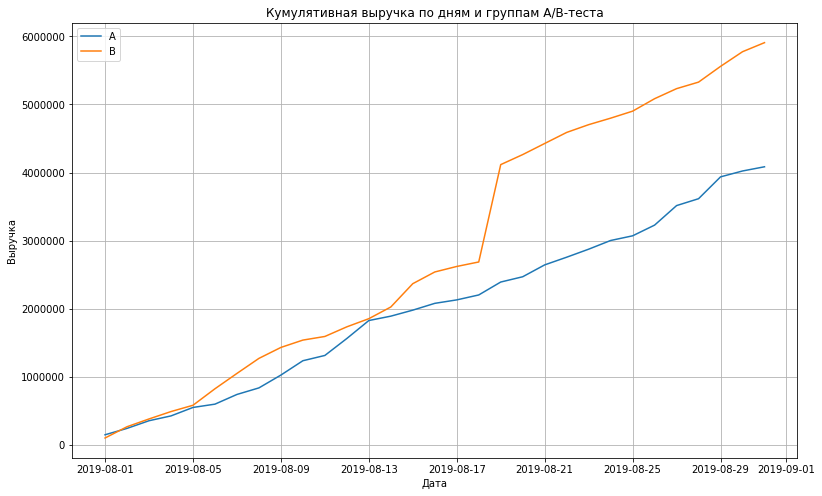

In [16]:
# выделяем данные по группа теста
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date', 'revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date', 'revenue', 'orders']]

# строим график кумулятивной выручки по группам
plt.figure(figsize=(13, 8))
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.title('Кумулятивная выручка по дням и группам A/B-теста')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label = 'A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label = 'B')
plt.legend()
plt.grid()
plt.show()

До 5 августа обе группы имели примерно одинаковую кумулятивную выручку, затем группа `B`, в которой тестируется нововведение, начала постепенно отрываться. 13 августа оба графика сходятся за счет большей выручки у группы `A` в этот день. Но затем график группы `B` начал возрастать быстрее. И 18 августа у этой группы произошел резкий скачок. Вероятно, это связано с одним или несколькими большими заказами, сделанным в этот день. После 19 августа выручка в группе `B` продолжила равномерно подниматься.

Выручка в группе `A` равномерно увеличивается в течение всего месяца эксперимента.

#### Кумулятивный средний чек по группам

Посмотрим, как изменялся в течение месяца средний чек у каждой из групп, разделив выручку на количество заказов и построив график.

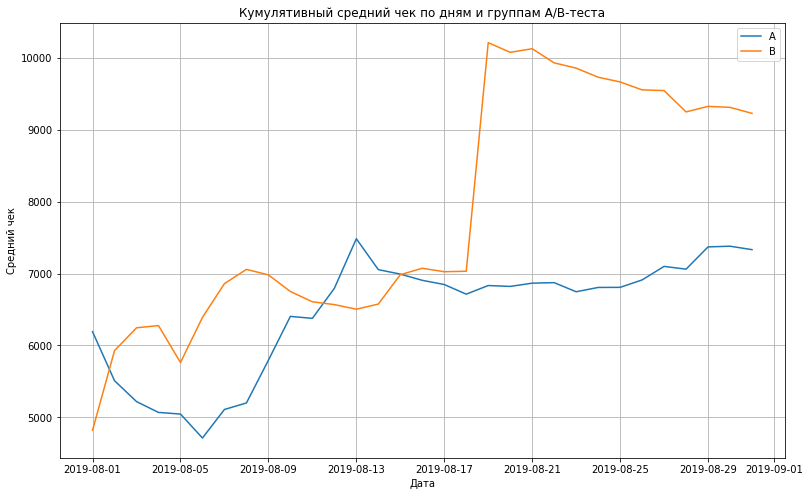

In [17]:
plt.figure(figsize=(13, 8))
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.title('Кумулятивный средний чек по дням и группам A/B-теста')
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.legend()
plt.grid()
plt.show()

Кумулятивный средний чек у группы `A` сначала снижался, достигнув минимума 6 августа, затем он начал резко расти. Довольно большой скачок 13 августа, видимо, был большой заказ. Далее средний чек начинает немного снижаться до 23 августа, стабилизируясь ближе к концу исследуемого периода и заканчивая ростом.

Кумулятивный средний чек у группы `B` в начале теста ниже, чем у группы `A`. Дальше он начинает расти, был небольшой спад 5 августа, затем снова подъем в течение 3 дней. С 12 августа по 15 августа средний чек группы `B` ниже среднего чека группы `A`. 15 августа на графике кумулятивной выручки у двух графиков значения сходятся. Это говорит о том, что в группе `A` появился довольно крупный заказ или было много обычных заказов, что находит отражение в графике со средним чеком. В этот день он достигает максимального значения в группе `A` за все время тестирования.

Аналогично графику кумулятивной выручки 18 августа средний чек группы `B` резко возрастает. Значит, предположение о большом заказе или заказах, скорее всего, верно. Далее средний чек группы `B` начинает снижаться. Вероятно, что больше не было крупных заказов.

#### Относительное изменение кумулятивного среднего чека группы B к группе A

Построим график, который покажет соотношения между среднем чеком групп `A` и `B`.

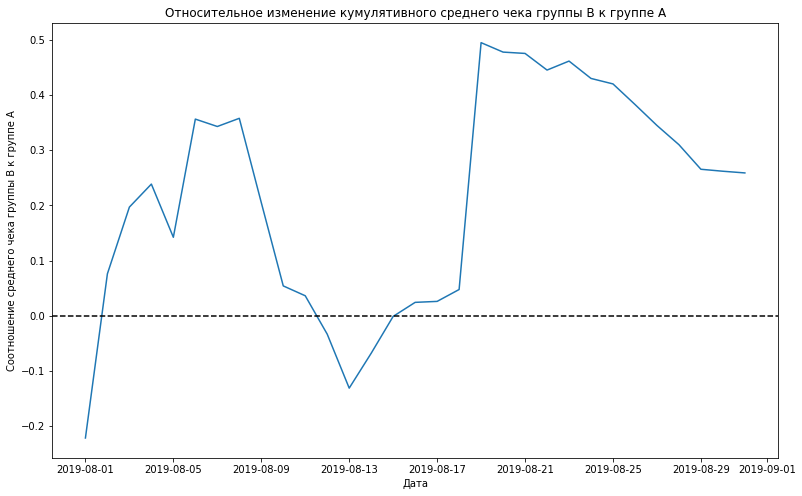

In [18]:
# соединяем две таблицы с данными по каждой группе
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, 
                                                   left_on='date', right_on='date', 
                                                   how='left', suffixes=['A', 'B'])

# строим график изменения кумулятивного среднего чека 
plt.figure(figsize=(13, 8))
plt.xlabel('Дата')
plt.ylabel('Соотношение среднего чека группы В к группе А')
plt.title('Относительное изменение кумулятивного среднего чека группы B к группе A')
plt.plot(mergedCumulativeRevenue['date'], 
         (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

График несколько раз меняет направление, значит, есть заказы, которые сильно влияют на значение среднего чека. Значение среднего чека несколько раз принимает отрицательные значения, т.е. кумулятивный чек группы `A` превышает значение группы `B`. Под конец исследуемого периода изменение графика становится спокойнее и идет на снижение. Скорее всего, график стабилизируется после аномальных значений в середине месяца.

#### Кумулятивная конверсия по группам

Теперь перейдет к анализу конверсии по группам. Для начала найдем кумулятивную конверсию в таблице `cumulativeData`, разделив число заказов на число посетителей. Затем выделим данные по группам тестирования и построим график изменения.

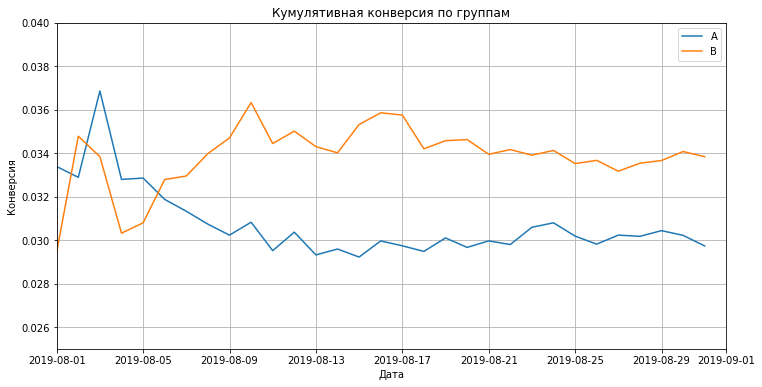

In [19]:
# добавляем столбец с конверсией
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# выделяем группы тестирования
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим график кумулятивной конверсии по группам
plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Конверсия')
plt.title('Кумулятивная конверсия по группам')
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.grid()

# задаем ограничения осей
plt.axis(["2019-08-01", '2019-09-01', 0.025, 0.04])
plt.show()

В самом начале проведения тестирования конверсии обеих групп сильно колебались. Резкий рост и затем падение конверсии в начале у группы `A` сменяется стабилизацией после 9 августа и далее ее значения колебались около значения 3%. В течение всего времени график колеблется в пределах 2,9% и 3,7% значений. Что незначительно.

У группы `B` значение кумулятивной конверсии сильнее меняется. Практически все значения кумулятивной конверсии группы `B` до 6 августа были меньше, чем у группы `A`. Ближе к концу месяца после 18 августа значения начинают стабилизироваться и держатся около 3,4%. Несмотря на большее количество изменений направления графика, он более стабильный, чем график конверсии группы `A` - в пределах 3% и 3,6%.

#### Относительное изменение кумулятивной конверсии группы B к группе A

Построим график относительного различия кумулятивных конверсий.

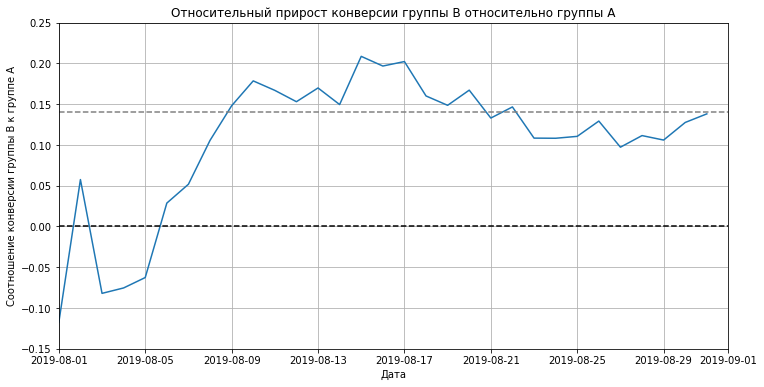

In [20]:
# объединяем группы конверсий
mergedCumulativeConversions = cumulativeDataA[['date','conversion']]\
.merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# строим график
plt.figure(figsize=(12, 6))
plt.xlabel('Дата')
plt.ylabel('Соотношение конверсии группы В к группе А')
plt.title('Относительный прирост конверсии группы B относительно группы A')
plt.plot(mergedCumulativeConversions['date'],
         mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1)

# задаем две оси X и ограничения по осям
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.14, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-09-01', -0.15, 0.25])
plt.grid()
plt.show()

Начиная с 6 августа конверсия группы `B` больше. С 11 августа колеблется около 14% прироста относительно группы `A`. Вероятно, что в дальнейшем у этого уровня и зафиксируется значение относительного прироста конверсии.

**Вывод**

В процессе анализа графиков кумулятивных выручки, среднего чека и конверсии было выявлено, что в данных есть большие значения - резкие изменения на графиках кумулятивной выручки по группам и кумулятивного среднего чека. Поэтому пока сложно сделать однозначные выводы. Необходимо проверить, насколько сильно аномалии влияют на параметры. 

### Анализ выбросов

#### Изучение количества заказов по пользователям

Посмотрим на число заказов у каждого пользователя и построим диаграмму распределения

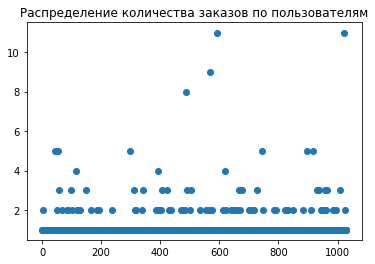

In [21]:
# группируем данные по пользователям и переименовываем столбцы
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1)\
.groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsers.columns = ['visitorId', 'orders']

# строи диаграмму распределения
x_values = pd.Series(range(0,len(ordersByUsers)))
plt.title('Распределение количества заказов по пользователям')
plt.scatter(x_values, ordersByUsers['orders'])
plt.show()

Много пользователей с 1-2 заказами. Совсем редки заказы больше 2. 

Посчитаем 95 и 99 перцентили, чтобы определить границу пользователей с большим количеством заказов.

In [22]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([2., 4.])

Получается, что не более 5% людей совершают более 2 заказов и все 1% людей делают больше 4. Установим границу в 2 заказа, значения больше которого будем считать аномально большими.

#### Изучение стоимости заказов

Построим точечный график распределения заказов. 

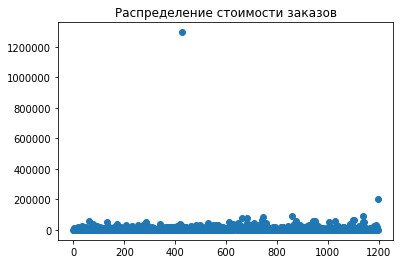

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.title('Распределение стоимости заказов')
plt.scatter(x_values, orders['revenue'])
plt.show()

Практически все значения находят до 60-70 тыс. Попробуем посмотреть на график, исключив выбросы и отфильтровав значения по оси Y меньше 100 тыс.

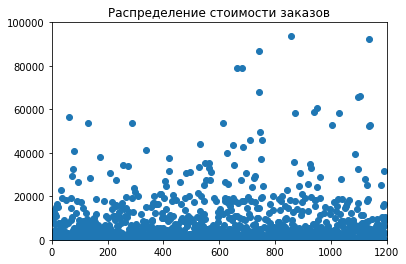

In [24]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.title('Распределение стоимости заказов')
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1200, 0, 100000])
plt.show()

Практически все значения находят до 30 тыс. Основная масса располагается до 20 тыс. Чтобы точнее определить границы стоимости заказа, посчитаем 95 и 99 перцентили.

In [25]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Заказы более 28 тыс. совершает всего 5% пользователей, а больше 58 233,20 только 1%. Поскольку большинство заказов находятся до 30 тыс., а 28 тыс. - это 95 перцентиль, то, чтобы отсечь большинство крупных заказов и оставить основную массы, возьмем 30 тыс. в качестве границы стоимости заказа.

**Вывод**

В данных действительно оказались аномальные значения. Чтобы проверить насколько они влияют на выборку, установили границы по заказам и по их стоимости - 2 и 30 тыс. соответственно.

### Статистическая значимость различий

Для начала подготовим исходную таблицу, которая будет содержать следующие данные:

* date — дата;
* ordersPerDateA — количество заказов в выбранную дату в группе A;
* revenuePerDateA — суммарная выручка в выбранную дату в группе A;
* ordersPerDateB — количество заказов в выбранную дату в группе B;
* revenuePerDateB — суммарная выручка в выбранную дату в группе B;
* ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
* revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
* ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
* revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
* visitorsPerDateA — количество пользователей в выбранную дату в группе A;
* visitorsPerDateB — количество пользователей в выбранную дату в группе B;
* visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
* visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.

In [26]:
# создадим переменную с посетителями в группе А на каждую дату и переменнуем столбцы
visitorsADaily = visitors[visitors['group']=='A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# создадим переменную, где будут собраны кумулятивные данные по количеству пользователей в группе A, и переименнуем столбцы
visitorsACummulative = visitorsADaily.apply(lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateA' : 'sum'}), axis=1)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

# аналогично создаем для группы В таблицу с посетитеоями на каждую дату и собираем кумулятивные данные
visitorsBDaily = visitors[visitors['group']=='B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']]
                                            .agg({'date' : 'max', 'visitorsPerDateB' : 'sum'}), axis=1)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

# сгруппируем данные по группе А, выбрав нужные столбцы, посчитаем сумму по выручке и найдем количество заказов на дату
ordersADaily = orders[orders['group']=='A'][['date', 'transactionId', 'visitorId', 'revenue']]\
.groupby('date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

# найдем кумулятивные данные по сумме выручки и количеству заказов на дату
ordersACummulative = ordersADaily.apply(lambda x: ordersADaily[ordersADaily['date'] <= x['date']]
                                        .agg({'date' : 'max',
                                              'ordersPerDateA' : 'sum', 
                                              'revenuePerDateA' : 'sum'}), axis=1).sort_values(by=['date'])
ordersACummulative.columns = ['date', 'ordersCummulativeA', 'revenueCummulativeA']


# аналогично для группы В: сначала группируем по сумме выручки и количеству заказов, затем собираем кумулятивные данные
ordersBDaily = orders[orders['group']=='B'][['date', 'transactionId', 'visitorId', 'revenue']]\
.groupby('date', as_index=False).agg({'transactionId' : pd.Series.nunique, 'revenue' : 'sum'})
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']]
                                        .agg({'date' : 'max', 
                                              'ordersPerDateB' : 'sum',
                                              'revenuePerDateB' : 'sum'}), axis=1).sort_values(by=['date'])
ordersBCummulative.columns = ['date', 'ordersCummulativeB', 'revenueCummulativeB']

# объединяем получившиеся таблицы в одну общую
data = ordersADaily.merge(ordersBDaily, left_on='date', right_on='date', how='left')\
.merge(ordersACummulative, on='date', how='left')\
.merge(ordersBCummulative, on='date', how='left')\
.merge(visitorsADaily, on='date', how='left')\
.merge(visitorsBDaily, on='date', how='left')\
.merge(visitorsACummulative, on='date', how='left')\
.merge(visitorsBCummulative, on='date', how='left')

data.head(5)

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


Таблица готова, теперь перейдем к изучению статистической значимости на "сырых" данных. 

Для проверки всех гипотез критический уровень статистической значимости принимается 0.05.

Создадим функцию, которая бы считала `p-value` и средние значения.

In [27]:
def significance(value, first, second, value2, sampleB, sampleA):
    print('Статистическая значимость', value, '(p-value): {0:.3f}'
          .format(stats.mannwhitneyu(first, second, True, 'two-sided')[1]))
    print('Относительный прирост', value2, ': {0:.3f}'.format(sampleB/sampleA-1))

#### Статистическая значимость различий в конверсии по "сырым" данным

Проверим следующую гипотезу:

* Нулевая гипотеза: Конверсия пользователей в группе А и В статистически не отличается;
* Альтернативная гипотеза: Конверсия пользователей в группе А и В различается.

In [28]:
# выделим группу А с пользователями, которые заказывали хотя бы 1 раз, и количеством совершённых заказов
ordersByUsersA = orders[orders['group']=='A'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersA.columns = ['visitorId', 'orders']

# выделим группу В с пользователями, которые заказывали хотя бы 1 раз, и количеством совершённых заказов
ordersByUsersB = orders[orders['group']=='B'].groupby('visitorId', as_index=False).agg({'transactionId': pd.Series.nunique})
ordersByUsersB.columns = ['visitorId', 'orders']

# создадим выборку группы А, где пользователям будет соответствовать количество заказов (0 - для пользователей без заказов)
sampleA = pd.concat([ordersByUsersA['orders'],
                     pd.Series(0,index=np.arange(data['visitorsPerDateA']
                                                 .sum()-len(ordersByUsersA['orders'])), name='orders')], axis=0)
# создадим аналогичную выборку для группы В
sampleB = pd.concat([ordersByUsersB['orders'],
                     pd.Series(0,index=np.arange(data['visitorsPerDateB']
                                                 .sum()-len(ordersByUsersB['orders'])), name='orders')], axis=0)

# применим функцию для подсчета конверсии и относительного прироста
significance('различия конверсии', sampleA, sampleB,
            'в конверсии между группами', (data['ordersPerDateB'].sum()/data['visitorsPerDateB'].sum()), 
             (data['ordersPerDateA'].sum()/data['visitorsPerDateA'].sum()))

Статистическая значимость различия конверсии (p-value): 0.017
Относительный прирост в конверсии между группами : 0.138


`P-value` меньше 0.05, поэтому нулевую гипотезу отвергаем. Сырые данные показывают, что в конверсии между группами есть довольно значимые различия. Относительный прирост конверсии групп `B` по отношению к группе `A` - 13,8%

#### Статистическая значимость различий в среднем чеке заказа по "сырым" данным

Перейдем к проверке гипотезы о среднем чеке:

* Нулевая гипотеза: Средний чек заказа пользователей в группе А и В статистически не отличается;
* Альтернативная гипотеза: Средний чек заказа пользователей в группе А и В различается.

In [29]:
significance('средних чеков между группами', orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'],
            'среднего чека группы B', orders[orders['group']=='B']['revenue'].mean(), 
             orders[orders['group']=='A']['revenue'].mean())

Статистическая значимость средних чеков между группами (p-value): 0.729
Относительный прирост среднего чека группы B : 0.259


Значение `p-value` значительно больше 0.05, значит не можем отвергнуть нулевую гипотезу. Т.е. нет оснований считать, что средние чеки у двух групп имеют различия. При этом, средний чек группы `B` значительно выше - на 26%, чем средний чек группы `A`. Видимо, сказываются аномалии в данных.

Перейдем к проверке гипотез, но уже по очищенным данным.

#### Статистическая значимость различий в конверсии по "очищенным" данным

Для начала очистим данные от выбросов. Ими являются пользователи, у которых больше 2 заказов и на сумму больше 30 тыс.

In [30]:
usersWithManyOrders = pd.concat([ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'], 
                                 ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId']], axis = 0)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitorId']
abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().sort_values()
abnormalUsers.shape

(68,)

Пользователей с аномальными значениями оказалось 68.

Теперь аналогичным образом сформируем две группы пользователей, но уже с очищенными данными.

In [31]:
sampleAFiltered = pd.concat([ordersByUsersA[np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])),
                                       name='orders')],axis=0)

sampleBFiltered = pd.concat([ordersByUsersB[np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))]['orders'],
                             pd.Series(0, index=np.arange(data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])),
                                       name='orders')],axis=0)

Снова проверим гипотезу о конверсии:

* Нулевая гипотеза: Конверсия пользователей в группе А и В статистически не отличается;
* Альтернативная гипотеза: Конверсия пользователей в группе А и В различается.

In [32]:
significance('различия конверсии', sampleAFiltered, sampleBFiltered,
            'в конверсии между группами', sampleBFiltered.mean(), sampleAFiltered.mean())

Статистическая значимость различия конверсии (p-value): 0.013
Относительный прирост в конверсии между группами : 0.172


`P-value` также меньше критического значения, как и в случае с "сырыми" данными. Значит есть основания отвергать нулевую гипотезу. 

Прирост стал немного больше - 17,2% в очищенных данных против 13,8% в сырых.

#### Статистическая значимость различий в среднем чеке по "очищенным" данным

Теперь очередь протестировать гипотезу о среднем чеке на данных без аномалий:

* Нулевая гипотеза: Средний чек заказа пользователей в группе А и В статистически не отличается;
* Альтернативная гипотеза: Средний чек заказа пользователей в группе А и В различается.

In [33]:
significance('средних чеков между группами', orders[np.logical_and(orders['group']=='A',
                                                       np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
                                 orders[np.logical_and(orders['group']=='B',
                                                       np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'],
            'среднего чека группы B', orders[np.logical_and(orders['group']=='B',
                                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean(), 
             orders[np.logical_and(orders['group']=='A',
                                    np.logical_not(orders['visitorId'].isin(abnormalUsers)))]['revenue'].mean().mean())

Статистическая значимость средних чеков между группами (p-value): 0.720
Относительный прирост среднего чека группы B : -0.023


Значение `p-value` по-прежнему значительно больше 0.05, значит снова не можем отвергнуть нулевую гипотезу. Т.е. нет оснований считать, что средние чеки у двух групп имеют различия. 
При этом, средний чек группы `B` стал меньше среднего чека группы `A`. Теперь разница между ними составляет 2% в пользу чека группы `A`.

Получается, что на средний чек сильно влияли аномально большие заказы.

**Вывод**

Проведя проверку гипотез по конверсии и по среднему чеку на "сырых" и на "очищенных" данных, можно сделать следующие выводы:

* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий;
* Относительный прирост конверсии в сырых данных ниже, чем у данных с удаленными аномалиями;
* Нет статистически значимого различия по среднему чеку между группами с "сырыми" и с "очищенными" данными;
* После удаления аномалий прирост в среднем чеке сильно изменился: в "сырых" данных прирост на стороне группы `B`, а в "очищенных" - у группы `A`.

### Выводы из A/B-теста

После обработки всех результатов проведенного A/B-теста, можно сделать следующие выводы:

* Есть статистически значимое различие по конверсии между группами как по сырым данным, так и после фильтрации аномалий;
* Нет статистически значимого различия по среднему чеку между группами с "сырыми" и с "очищенными" данными;
* График различия конверсии между группами сообщает, что результаты группы B лучше группы A: наблюдается рост и значение колеблется вокруг 14%, но все еще не зафиксировалось;
* График различия среднего чека часто меняется: на его основе удалось выявить выбросы. Стоит отметить, что к концу эксперимента колебания графика заметно уменьшились и есть тенденция к фиксации.

Исходя из выводов, указанных выше, тест следует продолжить, чтобы посмотреть, как поведут себя конверсия и средний чек. У обоих этих значений заметна тенденция к закреплению результата. Кроме того, не была выявлена статистическая разница между средними чеками. Возможно, она и не будет выявлена в дальнейшем эксперименте, но стоит это проверить.